# 주제 : 칼라 사진을 흑백으로!
--------------
## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## 데이터 소개
    - 이번 주제의 데이터는 protrait 데이터로 유명한 PFCN dataset을 이용합니다.
  ![PFCN dataset](https://www.researchgate.net/profile/Dawei_Li49/publication/334417334/figure/fig4/AS:832930272276492@1575597460956/Sample-images-from-the-PFCN-dataset.jpg)

     위의 이미지는 다음과 같은 것을 보여줍니다.  
    - 800x600의 사람 portrait 이미지  
     - ?????.png  
    - 사람 영역에 대한 흑백 portrait 이미지
     - ?????_matte.png
    - pfcn_original
     - 원본 800x600 이미지들
    - pfcn_small
     - colab용 100x75 이미지들



- 데이터 출처: 
 - [PFCN dataset](https://1drv.ms/u/s!ApwdOxIIFBH19Ts5EuFd9gVJrKTo)
 - [pfcn_small](https://drive.google.com/file/d/1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl/view?usp=sharing)

## 최종 목표

    - 작게 줄인 PFCN 데이터를 이용
    - 코렙에 구글 drive 연동
    - 큰 사진을 작게 줄이기
    - 이미지에 대한 오토인코더식 접근 방법
    - 칼라 사진을 흑백 사진으로 만드는 모델 이해
    - 흑백 사진을 칼라 사진으로 만드는 모델 이해

- 출제자 : 손근영 강사
---


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34


## Step 1. 도입전 기본 처리

### 문제 1. 구글 drive와 colab 연동하기

In [ ]:
# 구글 drive와 colab 연동하기
# https://onedrive.live.com/?authkey=%21ADkS4V32BUmspOg&cid=F5111408123B1D9C&id=F5111408123B1D9C%2115035&parId=F5111408123B1D9C%2115033&action=locate
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### 문제 2. pfcn 데이터 살펴보기

In [ ]:
# 데이터를 np array로 training에서 사람 이미지 한장을 불러오는 코드를 작성해주세요. (x로 변수 대입)
data_path = "/content/drive/MyDrive/[강의자료] 퀴즈처럼 풀면서 배우는 파이썬 딥러닝 300제+ 연습문제 패키치 Online/PART 1~3 강의자료/dataset"

import glob
import imageio

x = imageio.imread(data_path + "/training/00001.png")
# y = imageio.imread(data_path + "/training/00001_matte.png")

### 문제 3. x와 shape을 출력해보세요.

In [ ]:
# 데이터의 크기를 shape 함수를 통해 출력해주세요.
print(x.shape)

### 문제 4. x를 plt를 통하여 출력하세요.

In [ ]:
# x를 plt를 이용하여 출력하는 코드를 작성해보세요.
plt.imshow(x)
plt.show()

### 문제 5. (800, 600)의 의미지는 colab에서 돌리기에 너무 큽니다. (100, 75)로 이미지를 줄여보세요

In [ ]:
# x를 (800, 600, 3) -> (100, 75, 3)로 줄이고 plt에서 확인하는 코드를 작성하세요.
from skimage.transform import resize
x1= resize(x, (100, 75))

### 문제 6. pfcn_small.npz 데이터에서 학습, 테스트 데이터를 로드하세요.

In [2]:
# pfcn_small.npz에서 train_images, test_images를 np array로 로드하세요.
#https://drive.google.com/file/d/1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl/view?usp=sharing

!gdown --id 1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl

Downloading...
From: https://drive.google.com/uc?id=1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl
To: /content/pfcn_small.npz
100% 137M/137M [00:04<00:00, 33.8MB/s]


In [3]:
pfcn_small = np.load('/content/pfcn_small.npz')
train_images = pfcn_small["train_images"]
test_images = pfcn_small["test_images"]

### 문제 7. train_images에서 0이 아닌 값들을 출력해보세요.

In [4]:
# 하나의 이미지에 대한 모든 0이 아닌 값을 출력하는 코드를 작성하세요.
print(train_images[0][train_images[0] != 0][:5])

[0.23627451 0.34803922 0.64705882 0.24509804 0.35686275]


### 문제 8. train_images의 dtype을 출력해보세요.

In [5]:
# dtype을 이용하여 이미지의 np array type을 확인해보세요.
train_images[0].dtype

dtype('float64')

## Step 2. 전처리

### 문제 9. train/test 이미지 데이터의 범위 확인

In [6]:
#  test_images의 shape과 dtype, 0이 아닌 숫자를 출력하는 코드를 작성하세요.
print(test_images.shape)
print(test_images.dtype)
print(test_images[test_images != 0][:10])

(300, 100, 75, 3)
float64
[0.50980392 0.64117647 0.64313725 0.51568627 0.64705882 0.64901961
 0.53823529 0.65588235 0.66372549 0.52843137]


### 문제 10. train/test 이미지 데이터의 최소/최대값을 출력

In [7]:
# train/test 전체 데이터에서 min, max를 출력하는 코드를 작성하세요.
print(max(train_images.reshape(-1)), min(train_images.reshape(-1)))
print(max(test_images.reshape(-1)), min(test_images.reshape(-1)))

1.0 0.0
1.0 0.0


### 문제 11. train_images와 test_images로 흑백인 train_gray_images, test_gray_images를 생성하세요.

In [8]:
# train_images와 test_images로 흑백인 train_gray_images, test_gray_images를 생성하세요.
from skimage.color import rgb2gray
train_gray_images = rgb2gray(train_images)
test_gray_images = rgb2gray(test_images)

## Step 3. 시각화 방법

### 문제 12. train_image의 이미지를 5장 획득하여 (5, 100, 75, 3)의 shape을 출력하세요.

In [9]:
# (배치, 100, 75, 3)인 train_images에서 (5, 100, 75, 3)을 획득하는 코드를 작성하세요.
train_images[:5].shape

(5, 100, 75, 3)

### 문제 13. 획득한 5장의 의미지를 (100, 75 * 5, 3)의 shape으로 변경해보세요.

In [10]:
# np.hstack은 height 방향의 배열을 풀어서 width 방향으로 연결해줍니다.
# 해당 기능을 쓰면 (height, image_height, image_width, color)의 shape을 (image_height, image_width * height, color)으로 바꿔 줄 수 있습니다.
# 코드를 작성해보세요.
np.hstack(train_images[:5]).shape

(100, 375, 3)

### 문제 14. (100, 375, 3)이 된 tensor를 plt로 출력해보세요.

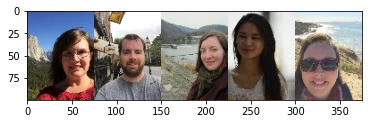

In [11]:
# 정답과 데이터 (28, 140, 3)의 이미지를 plt로 출력해보세요.
plt.imshow(np.hstack(train_images[:5]))

## Step 4. 칼라 -> 흑백 모델링

### 문제 15. 칼라 이미지를 흑백으로 변환하는 모델을 작성하세요.

In [12]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Input, Conv2D, Dropout, Dense, Conv2DTranspose, Flatten, MaxPool2D, Activation, BatchNormalization, concatenate
from keras.models import Model

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def unet_black():
    inputs = Input((100, 75, 3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D((2,2))(c1)
    d1 = Dropout(0.1)(p1)

    c2 = conv2d_block(d1, 32)
    p2 = MaxPool2D((2,2))(c2)
    d2 = Dropout(0.1)(p2)

    c3 = conv2d_block(d2, 64)
    p3 = MaxPool2D((2,2))(c3)
    d3 = Dropout(0.1)(p3)

    c4 = conv2d_block(d3, 128)
    p4 = MaxPool2D((2,2))(c4)
    d4 = Dropout(0.1)(p4)

    c5 = conv2d_block(d4, 256)

    u1 = Conv2DTranspose(128, 2, 2, output_padding=(0,1))(c5)
    u1 = concatenate((u1, c4))
    u1 = Dropout(0.1)(u1)
    c6 = conv2d_block(u1, 128)

    u2 = Conv2DTranspose(64, 2, 2, output_padding=(1,0))(c6)
    u2 = concatenate((u2, c3))
    u2 = Dropout(0.1)(u2)
    c7 = conv2d_block(u2, 64)

    u3 = Conv2DTranspose(32, 2, 2, output_padding=(0,1))(c7)
    u3 = concatenate((u3, c2))
    u3 = Dropout(0.1)(u3)
    c8 = conv2d_block(u3, 32)

    u4 = Conv2DTranspose(16, 2, 2, output_padding=(0,1))(c8)
    u4 = concatenate((u4, c1))
    u4 = Dropout(0.1)(u4)
    outputs = conv2d_block(u4, 16)

    outputs = Conv2D(1, (1,1), activation="sigmoid")(outputs)

    model = Model(inputs, outputs)
    return model

unet_black().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 75, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 75, 16)  448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 75, 16)  64         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

### 문제 16. 모델을 할당 받고 서머리를 출력해보세요.

In [13]:
# unet_black() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.
model = unet_black()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 75, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 100, 75, 16)  448         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 100, 75, 16)  64         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                            

### 문제 17. 만든 모델에 로스와 옵티마이저, 메트릭을 설정하세요.

In [14]:
# 만든 모델에 loss는 mae, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["accuracy"]
)

### 문제 18. 만든 모델에 train_images, train_gray_images를 학습시켜 보세요.

In [15]:
# train_images 학습시키고 5 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
hist = model.fit(train_images, train_gray_images, batch_size=64, epochs=5, verbose=1, validation_data=(test_images, test_gray_images))

Epoch 1/5
27/27 [==============================] - 20s 281ms/step - loss: 0.0197 - accuracy: 0.0110 - val_loss: 0.0656 - val_accuracy: 0.0180
Epoch 2/5
27/27 [==============================] - 5s 199ms/step - loss: 0.0050 - accuracy: 0.0116 - val_loss: 0.0550 - val_accuracy: 0.0181
Epoch 3/5
27/27 [==============================] - 5s 199ms/step - loss: 0.0037 - accuracy: 0.0116 - val_loss: 0.0538 - val_accuracy: 0.0181
Epoch 4/5
27/27 [==============================] - 5s 200ms/step - loss: 0.0028 - accuracy: 0.0116 - val_loss: 0.0477 - val_accuracy: 0.0181
Epoch 5/5
27/27 [==============================] - 5s 201ms/step - loss: 0.0024 - accuracy: 0.0116 - val_loss: 0.0417 - val_accuracy: 0.0181


### 문제 19. 학습 진행 사항을 plt으로 출력하세요.

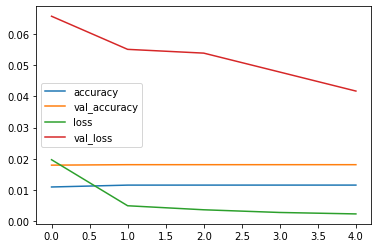

In [16]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history["accuracy"], label="accuracy")
plt.plot(hist.history["val_accuracy"], label="val_accuracy")
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

## Step 5. 흑백 모델 결과 확인

### 문제 20. 완성된 모델에서 test_image를 1장 넣고 결과를 res 변수에 저정하세요.

In [17]:
# 모델에 test_mages 중 1장을 넣고 결과를 받는 코드를 작성하세요.
res = model.predict(test_images[0:1])

### 문제 21. res와 test_gray_images[1]를 width 방향으로 결합하여 plt로 출력하세요.

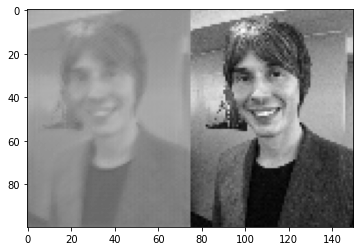

In [18]:
# res와 test_gray_images[1]를 width 방향으로 결합하여 (100, 75 * 3, 1) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.
plt.imshow(np.concatenate((res.reshape(100, 75), test_gray_images[0].reshape(100, 75)), axis=1), cmap="gray")
plt.show()

### 문제 22. 5장의 test_images를 모델에 넣은 뒤 결과를 문제 21 방식으로 비교하세요.

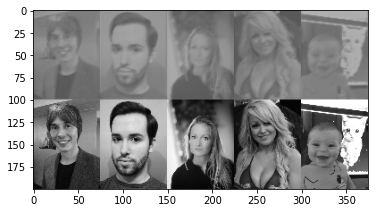

In [38]:
# 5장의 이미지를 모델에 넣고 결과를 21번과 같은 방식으로 비교하는 코드를 작성하세요.
res5 = model.predict(test_images[:5])
res5 = np.hstack(res5)
plt.imshow(np.concatenate((res5.reshape(100, -1), test_gray_images[:5].transpose(1, 0, 2).reshape(100, -1))), cmap="gray")
plt.show()

## Step 6. 더욱 간단한 칼라 -> 흑백 모델링

### 문제 23. 칼라 이미지를 흑백으로 변환하는 모델을 작성하세요.

In [51]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras import backend as K
def simple_black():
    inputs = Input((100, 75, 3))

    x = Conv2D(30, 1, use_bias=False)(inputs)
    x = Conv2D(1, 1, use_bias=False)(x)
    x = K.clip(x, 0.0, 1.0)
    return Model(inputs, x)

### 문제 24. 모델을 할당 받고 서머리를 출력해보세요.

In [42]:
# simple_black() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.
simple = simple_black()
simple.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 75, 3)]      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 100, 75, 30)       90        
                                                                 
 conv2d_39 (Conv2D)          (None, 100, 75, 1)        30        
                                                                 
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


### 문제 25. 만든 모델에 로스와 옵티마이저, 메트릭을 설정하세요.

In [45]:
# 만든 모델에 loss는 mae, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
simple.compile(
    loss="mse",
    optimizer="adam",
    metrics=["accuracy"]
)

### 문제 26. 만든 모델에 train_images, train_gray_images를 학습시켜 보세요.

In [46]:
# train_images 학습시키고 5 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
hist = simple.fit(train_images, train_gray_images, batch_size=64, epochs=5, verbose=1, validation_data=(test_images, test_gray_images))

Epoch 1/5
27/27 [==============================] - 2s 38ms/step - loss: 0.4223 - accuracy: 0.0025 - val_loss: 0.1818 - val_accuracy: 0.0048
Epoch 2/5
27/27 [==============================] - 1s 21ms/step - loss: 0.0871 - accuracy: 0.0077 - val_loss: 0.0227 - val_accuracy: 0.0181
Epoch 3/5
27/27 [==============================] - 0s 16ms/step - loss: 0.0101 - accuracy: 0.0116 - val_loss: 0.0040 - val_accuracy: 0.0181
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 0.0045 - accuracy: 0.0116 - val_loss: 0.0037 - val_accuracy: 0.0181
Epoch 5/5
27/27 [==============================] - 0s 16ms/step - loss: 0.0043 - accuracy: 0.0116 - val_loss: 0.0035 - val_accuracy: 0.0181


### 문제 27. 학습 진행 사항을 plt으로 출력하세요.

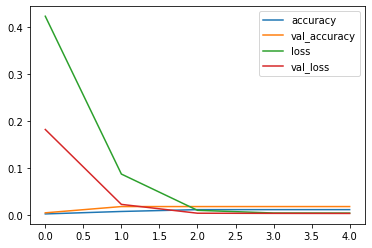

In [47]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history["accuracy"], label="accuracy")
plt.plot(hist.history["val_accuracy"], label="val_accuracy")
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

## Step 7. 흑백 모델 결과 확인

### 문제 28. 완성된 모델에서 test_image를 1장 넣고 결과를 res 변수에 저정하세요.

In [48]:
# 모델에 test_mages 중 1장을 넣고 결과를 받는 코드를 작성하세요.
res = simple.predict(test_images[0:1])

### 문제 29. res와 test_gray_images[1]를 width 방향으로 결합하여 plt로 출력하세요.

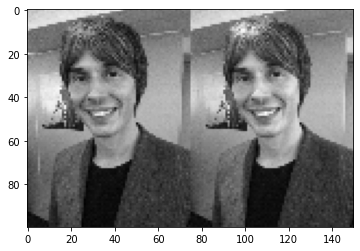

In [49]:
# res와 test_gray_images[1]를 width 방향으로 결합하여 (100, 75 * 3, 1) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.
plt.imshow(np.concatenate((res.reshape(100, 75), test_gray_images[0].reshape(100, 75)), axis=1), cmap="gray")
plt.show()

### 문제 30. 5장의 test_images를 모델에 넣은 뒤 결과를 문제 21 방식으로 비교하세요.

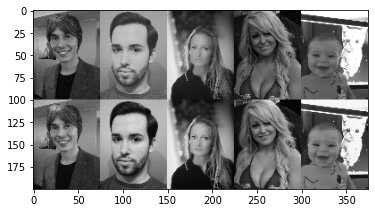

In [50]:
# 5장의 이미지를 모델에 넣고 결과를 21번과 같은 방식으로 비교하는 코드를 작성하세요.
res5 = simple.predict(test_images[:5])
res5 = np.hstack(res5)
plt.imshow(np.concatenate((res5.reshape(100, -1), test_gray_images[:5].transpose(1, 0, 2).reshape(100, -1))), cmap="gray")
plt.show()

## Step 8. 극단적 선형 흑백 모델

### 문제 31. 극단적으로 단순한 선형 흑백 모델을 구현하세요.

In [57]:
((np.ones_like(train_images[0]) + np.array([0.30, 0.59, 0.11])).sum(axis=2)).shape

(100, 75)

In [67]:
# 극단적으로 단순한 rgb to gray 함수를 구현하세요
# 0.30*R + 0.59*G + 0.11*B = val
def rgb2gray(imgs):
    return (imgs + np.array([0.30, 0.59, 0.11])).sum(axis=2)

### 문제 32. res와 test_gray_images[1]를 width 방향으로 결합하여 plt로 출력하세요.

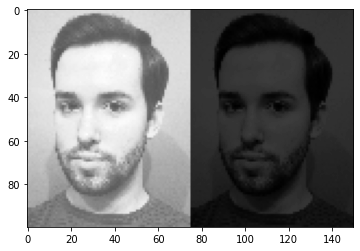

In [71]:
# res와 test_gray_images[1]를 width 방향으로 결합하여 (100, 75 * 3, 1) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.
res = rgb2gray(test_images[1])
plt.imshow(np.concatenate((res.reshape(100, 75), test_gray_images[1].reshape(100, 75)), axis=1), cmap="gray")
plt.show()

In [65]:
res.shape

(100, 75)

### 문제 33. 5장의 test_images를 모델에 넣은 뒤 결과를 문제 21 방식으로 비교하세요.

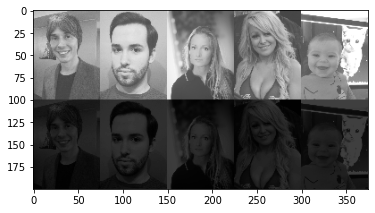

In [72]:
# 5장의 이미지를 모델에 넣고 결과를 21번과 같은 방식으로 비교하는 코드를 작성하세요.
res5 = np.array([rgb2gray(img) for img in test_images[:5]])
res5 = np.hstack(res5)
plt.imshow(np.concatenate((res5.reshape(100, -1), test_gray_images[:5].transpose(1, 0, 2).reshape(100, -1))), cmap="gray")
plt.show()

## Step 9. 모델 저장 및 로드, 다운

### 문제 34. 모델을 저장하세요.

In [31]:
# 모델을 저장하는 코드를 작성하세요.
model.save("./lecture005-1.h5")
simple.save("./lecture005-2.h5")

### 문제 35. 모델 파일을 새로운 모델에 로드하세요.

In [32]:
# 모델을 로드하는 코드를 작성하세요.
new_model = tf.keras.models.load_model("./lecture005-1.h5")
new_model2 = tf.keras.models.load_model("./lecture005-2.h5")

### 문제 36. 로드한 모델을 test 데이터로 평가해보세요.


In [33]:
# 로드한 모델을 test 데이터로 평가해보세요.
new_model.predict(test_images[10])
new_model2.predict(test_images[10])

### 문제 37. 모델을 내 컴퓨터에 저장해보세요

In [34]:
# 모델을 내 컴퓨터에 저장해보세요.
from google.colab import files
files.download("./lecture005-1.h5")
files.download("./lecture005-2.h5")